In [1]:
import scanpy as sc # scanpy library import for h5ad file
import scipy.io # to import the matrix file
import pandas as pd # dataframe management


adata = sc.read_h5ad("GSE227828.h5ad") # reading the output file 
db_cells_GSM7109167 = pd.read_csv('Input Data/GSM7109167_PT1_barcodes.tsv', sep='\t' , header = None)[0].tolist()
# we retrieve the first column containing the barcodes and place them in a list
db_genes_name_GSM7109167 = pd.read_csv('Input Data/GSM7109167_PT1_features.tsv', sep='\t' , header = None)[1].tolist()
# We retrieve the second column containing the gene names and place them in a list. 
db_genes_id_GSM7109167 = pd.read_csv('Input Data/GSM7109167_PT1_features.tsv', sep='\t' , header = None)[0].tolist()
# We retrieve the first column containing the Ensembl ids and place them in a list.
matrix_GSM7109167 = scipy.io.mmread("Input Data/GSM7109167_PT1_matrix.mtx").tocsc() #compressed Sparse column

# idem 
db_cells_GSM7109168 = pd.read_csv('Input Data/GSM7109168_PT5_barcodes.tsv', sep='\t' , header = None)[0].tolist()
db_genes_name_GSM7109168 = pd.read_csv('Input Data/GSM7109168_PT5_features.tsv', sep='\t' , header = None)[1].tolist()
db_genes_id_GSM7109168 = pd.read_csv('Input Data/GSM7109168_PT5_features.tsv', sep='\t' , header = None)[0].tolist()
matrix_GSM7109168 = scipy.io.mmread("Input Data/GSM7109168_PT5_matrix.mtx").tocsc()

# we add to the barcodes the id of the patient from which they originate 
db_cells_GSM7109167 = [f'{cell}_GSM7109167' for cell in db_cells_GSM7109167]
db_cells_GSM7109168 = [f'{cell}_GSM7109168' for cell in db_cells_GSM7109168]



In [2]:
# More interesting to make a function that will automate this step
adata_GSM7109167 = sc.AnnData(X=matrix_GSM7109167.T) # we create our anndata file 
adata_GSM7109167.var['gene_names'] = db_genes_name_GSM7109167 # add the gene_names column to the anndata variables
adata_GSM7109167.var["gene_id"] = db_genes_id_GSM7109167 # we also add the id 
adata_GSM7109167.obs['cell_barcodes'] = db_cells_GSM7109167 # add cell ids to observed anndata

# idem
adata_GSM7109168 = sc.AnnData(X=matrix_GSM7109168.T)
adata_GSM7109168.var['gene_names'] = db_genes_name_GSM7109168
adata_GSM7109168.var["gene_id"] = db_genes_id_GSM7109168
adata_GSM7109168.obs['cell_barcodes'] = db_cells_GSM7109168

# combine our two anndata files
combined_adata = Combined_adata = sc.concat([adata_GSM7109167, adata_GSM7109168], axis=0, # axis = 0 , we add the cells    
    merge='unique'  # data redundancy
)

c:\Users\lukyl\anaconda3\lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


C:\Users\lukyl\AppData\Local\Temp\ipykernel_23428\2092386652.py:4: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  combined_adata.var['mt'] = combined_adata.var.index.str.startswith('MT-') # if the gene name starts with ... we classify it
c:\Users\lukyl\anaconda3\lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\lukyl\anaconda3\lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\lukyl\AppData\Local\Temp\ipykernel_23428\2092386652.py:16: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with ig

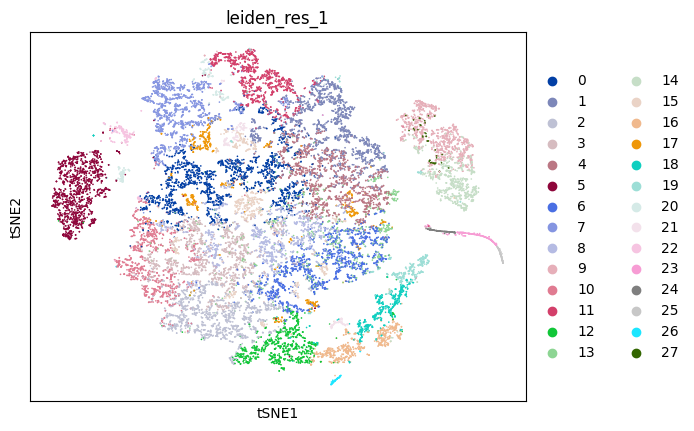

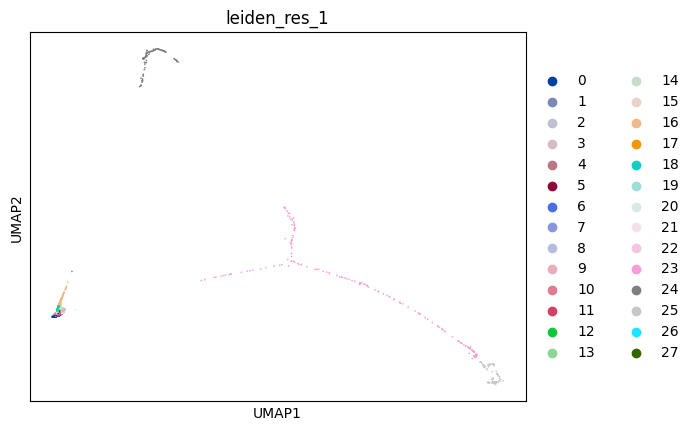

In [3]:

combined_adata.var.set_index(combined_adata.var.columns[0], inplace=True) # place the first column like the indexes
combined_adata.obs.set_index(combined_adata.obs.columns[0], inplace=True)
combined_adata = combined_adata[: , combined_adata.X.sum(axis = 0) > 0] # if a gene is not expressed in any cell, it is removed
combined_adata.var['mt'] = combined_adata.var.index.str.startswith('MT-') # if the gene name starts with ... we classify it 
combined_adata.var['ribo'] = combined_adata.var.index.str.contains('RPS|RPL|MRP')
combined_adata.var['hb'] = combined_adata.var.index.str.contains('^HB[ABEDGQZ]')

combined_adata.X = combined_adata.X.astype('float32') # transformation of our values into float otherwise error in the PCA
sc.pp.pca(combined_adata, n_comps=50) # principal component analysis 


sc.pp.calculate_qc_metrics(combined_adata, qc_vars=['mt', 'ribo', 'hb'], inplace=True) # calculates metrics according to whether qc_vars is true or false
sc.pp.normalize_total(combined_adata, target_sum=1e6)  # Normalize cells
sc.pp.log1p(combined_adata)  # log (1 + X)
sc.pp.neighbors(combined_adata, n_neighbors=10, use_rep='X_pca') # algo neighbors
sc.tl.leiden(combined_adata, resolution=1.0) #algo leiden
sc.pp.highly_variable_genes(combined_adata)  # Selecting the most variable genes
combined_adata.obs['leiden_res_1'] = combined_adata.obs['leiden']
sc.tl.tsne(combined_adata, n_pcs=20, random_state=42) # tsne

# View t-SNE results
sc.pl.tsne(combined_adata, color=['leiden_res_1'], save='_tsne')  

sc.tl.umap(combined_adata, n_components=20) # umap

# View Umap results
sc.pl.umap(combined_adata, color=['leiden_res_1'], save='_umap') 


In [8]:
print(combined_adata)

AnnData object with n_obs × n_vars = 21582 × 25537
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'leiden', 'leiden_res_1'
    var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'log1p', 'neighbors', 'leiden', 'hvg', 'tsne', 'leiden_res_1_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


In [ ]:
print(combined_adata.obs)


                              n_genes_by_counts  log1p_n_genes_by_counts  \
cell_barcodes                                                              
AGGACTTATGATTTCCA_GSM7109167                428                 6.061457   
CTCAAGACGAAAGCACG_GSM7109167                423                 6.049733   
AGCGCTGGCTACGGCTC_GSM7109167                433                 6.073045   
TCACATTTACCTTCGTA_GSM7109167                377                 5.934894   
ATACCGAATGTCTTGCG_GSM7109167                419                 6.040255   
...                                         ...                      ...   
ATTTCACCGACTACCCT_GSM7109168               5322                 8.579792   
ATTCAGGGCTGGAGAAA_GSM7109168               5506                 8.613775   
GAACACTTACTACGGTA_GSM7109168               4589                 8.431635   
CTACATTGCTGATTCAC_GSM7109168               5902                 8.683216   
GAATAGAGCTTTGCAGT_GSM7109168               5721                 8.652074   

           

In [10]:
print(combined_adata.var)

                     gene_id     mt   ribo     hb  n_cells_by_counts  \
gene_names                                                             
MIR1302-2HG  ENSG00000243485  False  False  False                  1   
AL627309.1   ENSG00000238009  False  False  False                 55   
AL627309.5   ENSG00000241860  False  False  False                281   
LINC01409    ENSG00000237491  False  False  False                958   
FAM87B       ENSG00000177757  False  False  False                  4   
...                      ...    ...    ...    ...                ...   
AC004556.3   ENSG00000276345  False  False  False                  6   
AC233755.2   ENSG00000277856  False  False  False                 54   
AC233755.1   ENSG00000275063  False  False  False                 48   
AC136612.1   ENSG00000275869  False  False  False                  1   
AC007325.4   ENSG00000278817  False  False  False                  5   

             mean_counts  log1p_mean_counts  pct_dropout_by_cou